In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('seaborn')
import geopandas as gpd
%matplotlib inline 
pd.plotting.register_matplotlib_converters()
import seaborn as sns
print("Setup Complete")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Setup Complete


Import the data (make sure you update this on a daily basis)

In [3]:
conf_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
reco_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

In [82]:
conf_df.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
0,NaN,Thailand,15.0,101.0,2,3,5,7,8,8,...,75,82,114,147,177,212,272,322,411,599
1,NaN,Japan,36.0,138.0,2,1,2,2,4,4,...,701,773,839,825,878,889,924,963,1007,1086


In [83]:
conf_df.groupby('Country/Region').count()

,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Albania,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Algeria,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Andorra,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Angola,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uzbekistan,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Venezuela,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Vietnam,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [70]:
dates = conf_df.columns[4:]

conf_df_long = conf_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')

deaths_df_long = death_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Deaths')

recv_df_long = reco_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Recovered')

full_table = pd.concat([conf_df_long, deaths_df_long['Deaths'], recv_df_long['Recovered']], 
                       axis=1, sort=False)

full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Thailand,15.0000,101.0000,1/22/20,2,0,0
1,NaN,Japan,36.0000,138.0000,1/22/20,2,0,0
2,NaN,Singapore,1.2833,103.8333,1/22/20,0,0,0
3,NaN,Nepal,28.1667,84.2500,1/22/20,0,0,0
4,NaN,Malaysia,2.5000,112.5000,1/22/20,0,0,0


In [73]:
full_table = full_table[full_table['Province/State'].str.contains(',')!=True]
full_table['Country/Region'] = full_table['Country/Region'].replace('Korea, South', 'South Korea')
full_table.to_csv('covid_19_full_updated.csv', index=False)

In [74]:
full_table = pd.read_csv('covid_19_full_updated.csv')

In [75]:
full_table.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Thailand,15.0000,101.0000,1/22/20,2,0,0
1,NaN,Japan,36.0000,138.0000,1/22/20,2,0,0
2,NaN,Singapore,1.2833,103.8333,1/22/20,0,0,0
3,NaN,Nepal,28.1667,84.2500,1/22/20,0,0,0
4,NaN,Malaysia,2.5000,112.5000,1/22/20,0,0,0


In [81]:
full_table.groupby(['Country/Region' , 'Date']).count()

Province/State  Lat  Long  Confirmed  Deaths  \
Country/Region Date                                                    
Afghanistan    1/22/20               0    1     1          1       1   
               1/23/20               0    1     1          1       1   
               1/24/20               0    1     1          1       1   
               1/25/20               0    1     1          1       1   
               1/26/20               0    1     1          1       1   
...                                ...  ...   ...        ...     ...   
Zimbabwe       3/5/20                0    1     1          1       1   
               3/6/20                0    1     1          1       1   
               3/7/20                0    1     1          1       1   
               3/8/20                0    1     1          1       1   
               3/9/20                0    1     1          1       1   

                        Recovered  
Country/Region Date                
Afghanistan    1/22/20          1  
               1/23/20          1  
               1/24/20          1  
               1/25/20          1  
               1/26/20          1  
...                           ...  
Zimbabwe       3/5/20           1  
               3/6/20           1  
               3/7/20           1  
               3/8/20           1  
               3/9/20           1  

[10431 rows x 6 columns]

In [5]:
cols = conf_df.keys()

Get all the dates for the outbreak

In [6]:
conf = conf_df.loc[:, cols[4]:cols[-1]]
death = death_df.loc[:, cols[4]:cols[-1]]
reco = reco_df.loc[:, cols[4]:cols[-1]]

In [7]:
conf.head(2)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
0,2,3,5,7,8,8,14,14,14,19,...,75,82,114,147,177,212,272,322,411,599
1,2,1,2,2,4,4,7,7,11,15,...,701,773,839,825,878,889,924,963,1007,1086


In [8]:
dates = conf.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 
china_cases_conf = []
china_cases_reco = []
china_cases_death = []
china_cases_active =[]

italy_cases_conf = []
italy_cases_reco = []
italy_cases_death = []
italy_cases_active = []


india_cases_conf = []
india_cases_reco = []
india_cases_death = []
india_cases_active = []
j=0
for i in dates:
    
    confirmed_sum = conf[i].sum()
    death_sum = death[i].sum()
    recovered_sum = reco[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    #china_cases.append(conf_df[conf_df['Country/Region']=='China'][i].sum())
    #italy_cases.append(conf_df[conf_df['Country/Region']=='Italy'][i].sum())
    india_cases_conf.append(conf_df[conf_df['Country/Region']=='India'][i].sum())
    india_cases_reco.append(reco_df[reco_df['Country/Region']=='India'][i].sum())
    india_cases_death.append(death_df[death_df['Country/Region']=='India'][i].sum())
    india_cases_active.append(india_cases_conf[j] - india_cases_reco[j] - india_cases_death[j])
    
    j = j+1

In [9]:
india_cases_conf_df = pd.DataFrame(index=dates,data=india_cases_conf, columns=['conf_cases'])
india_cases_reco_df = pd.DataFrame(index=dates,data=india_cases_reco, columns=['reco_cases'])
india_cases_death_df = pd.DataFrame(index=dates,data=india_cases_death, columns=['death_cases'])
india_cases_active_df = pd.DataFrame(index=dates,data=india_cases_active, columns=['activ_cases'])
    

In [10]:
india_full = pd.concat([india_cases_conf_df,india_cases_reco_df,india_cases_death_df,india_cases_active_df], axis=1)

In [11]:
india_full.head(3)

,conf_cases,reco_cases,death_cases,activ_cases
1/22/20,0,0,0,0
1/23/20,0,0,0,0
1/24/20,0,0,0,0


In [12]:
#total confirmed cases in the world
world_df = pd.DataFrame(index=dates,data=world_cases, columns=['conf_cases'])
world_df['daily_new_cases'] = world_df.diff()
world_df['daily_new_cases'][0] = world_df['conf_cases'][0]
world_df['daily_new_cases'] =world_df['daily_new_cases'].astype('int64')

/home/ryan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
world_df.head(2)

,conf_cases,daily_new_cases
1/22/20,555,555
1/23/20,653,98


In [14]:
total_death_df = pd.DataFrame(index=dates,data=total_deaths, columns=['total_death'])
total_death_df['new_death'] = total_death_df.diff()
total_death_df['new_death'][0] = total_death_df['total_death'][0] 
total_death_df['new_death'] = total_death_df['new_death'].astype('int64')

/home/ryan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
total_reco_df = pd.DataFrame(index=dates,data=total_recovered, columns=['total_recovered'])
total_reco_df['new_reco'] = total_reco_df.diff()
total_reco_df['new_reco'][0] = total_reco_df['total_recovered'][0] 
total_reco_df['new_reco'] = total_reco_df['new_reco'].astype('int64')

/home/ryan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
total_reco_df.head(3)

,total_recovered,new_reco
1/22/20,28,28
1/23/20,30,2
1/24/20,36,6


In [17]:

##this is tricky but true as it is daily new active cases being found both way it give same ans
total_active_df = pd.DataFrame(index=dates,data=total_active, columns=['total_active'])

#total_active_df['new_active111'] = world_df['daily_new_cases'] - total_death_df['new_death'] - total_reco_df['new_reco']
total_active_df['new_active'] = total_active_df['total_active'].diff()
total_active_df['new_active'][0] = total_active_df['total_active'][0] 
total_active_df['new_active'] = total_active_df['new_active'].astype('int64')

total_active_df=total_active_df.clip(lower =0)

/home/ryan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [19]:
world_full = pd.concat([world_df,total_reco_df,total_death_df,total_active_df], axis=1)

In [20]:
world_full.head(3)

,conf_cases,daily_new_cases,total_recovered,new_reco,total_death,new_death,total_active,new_active
1/22/20,555,555,28,28,17,17,510,510
1/23/20,653,98,30,2,18,1,605,95
1/24/20,941,288,36,6,26,8,879,274


In [21]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

Future forcasting

In [22]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

Convert integer into datetime for better visualization

In [23]:
# start = '1/22/2020'
# start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
# future_forcast_dates = []
# for i in range(len(future_forcast)):
#     future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))


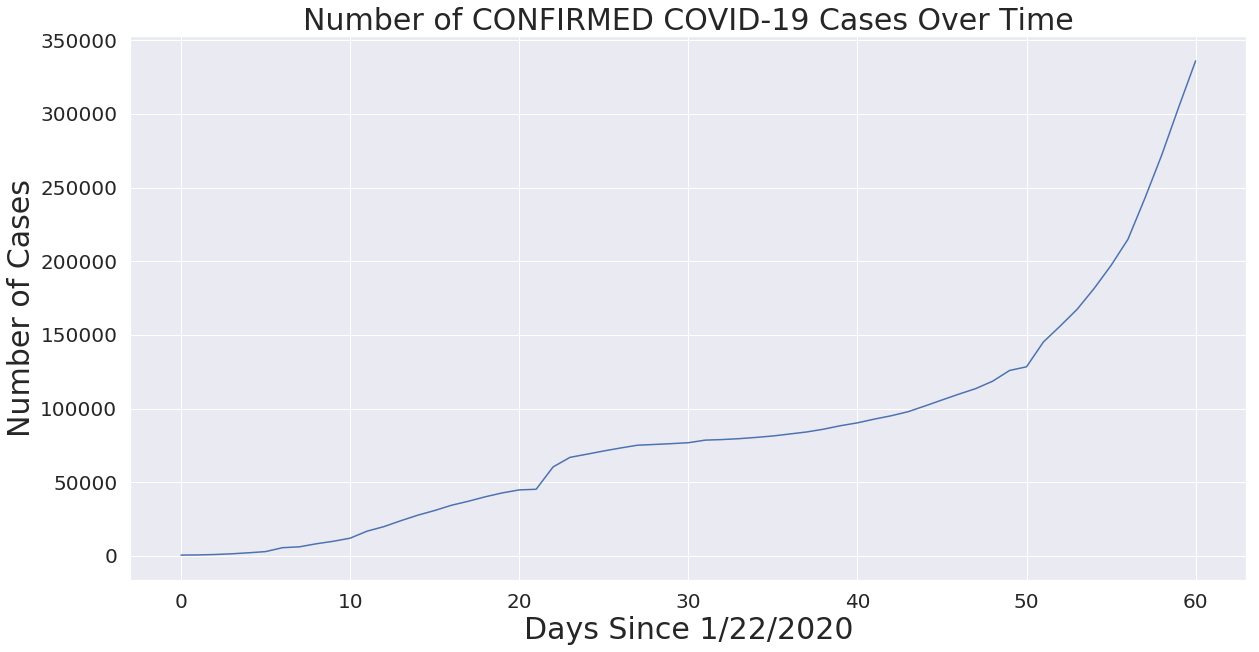

In [24]:

sns.set(context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=2,
    color_codes=True,
    rc=None)

plt.figure(figsize=(20, 10))
plt.title('Number of CONFIRMED COVID-19 Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size=30)
sns.lineplot(data=world_full.reset_index()['conf_cases']);
#sns.regplot(x=world_full.index ,y = world_full.reset_index()['world_cases']);
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

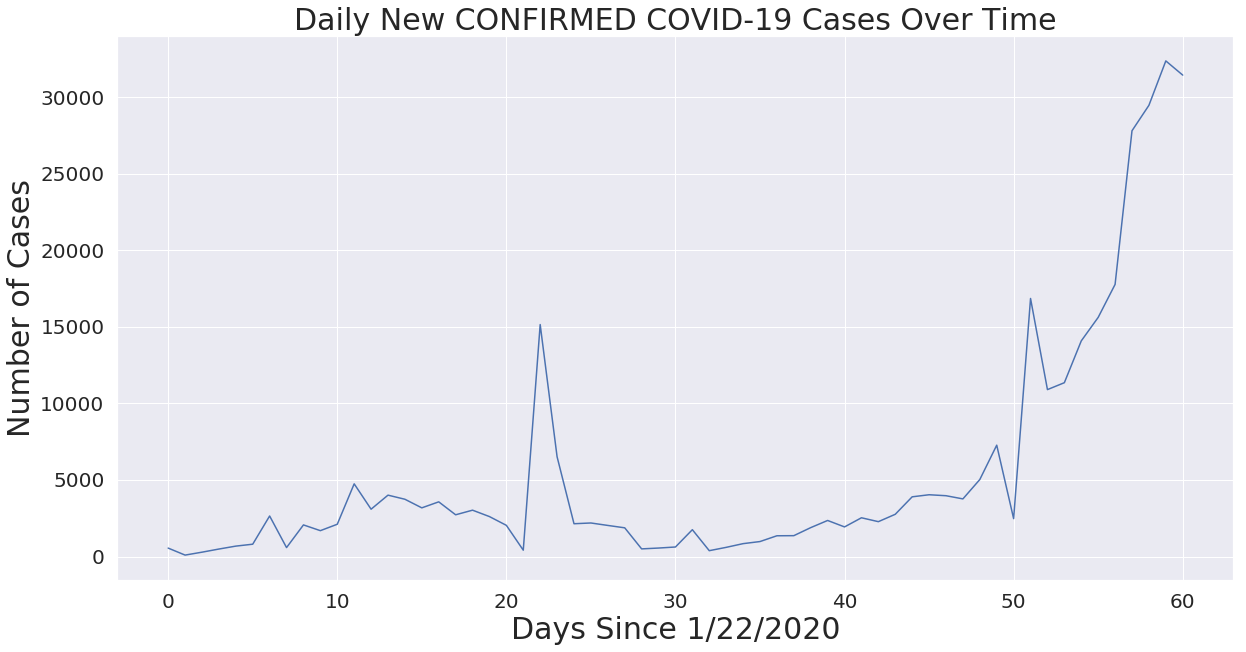

In [25]:

sns.set(context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=2,
    color_codes=True,
    rc=None)

plt.figure(figsize=(20, 10))
plt.title('Daily New CONFIRMED COVID-19 Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size=30)
sns.lineplot(data=world_full.reset_index()['daily_new_cases']);
#sns.regplot(x=world_full.index ,y = world_full.reset_index()['world_cases']);
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

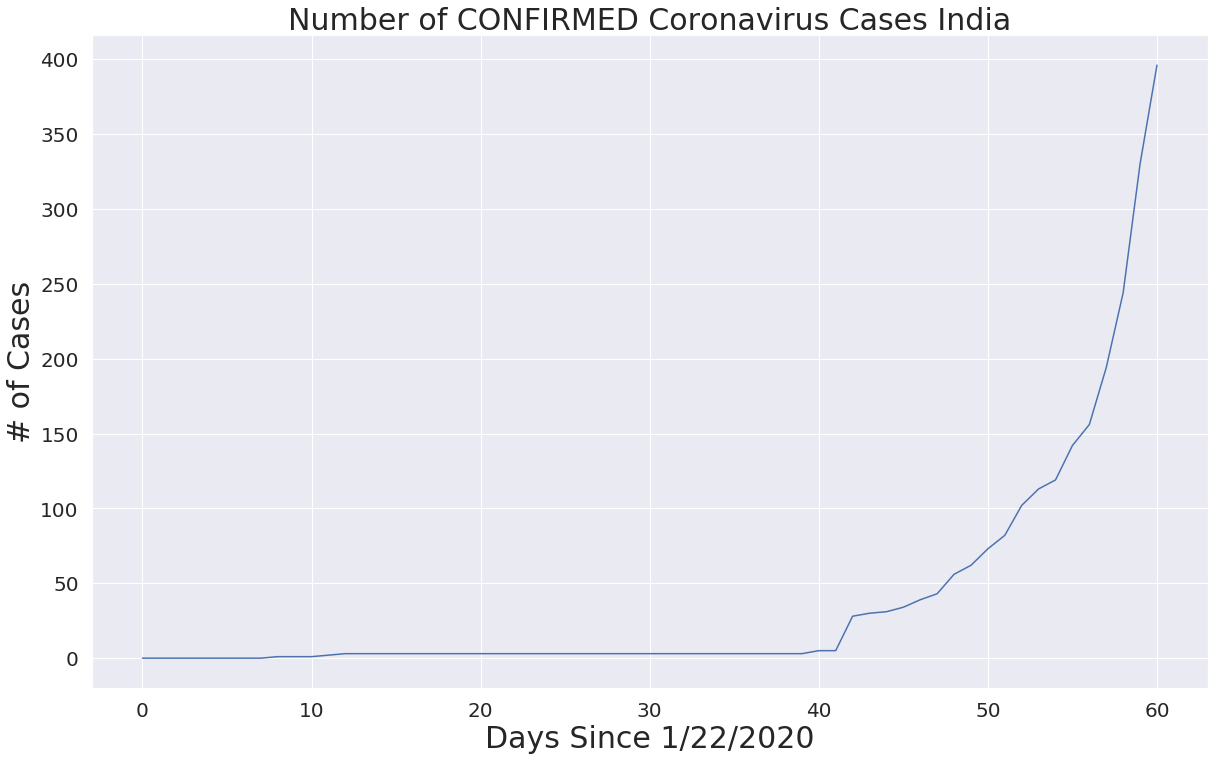

In [26]:
plt.figure(figsize=(20, 12))
sns.lineplot(data=india_full.reset_index()['conf_cases']);
plt.title('Number of CONFIRMED Coronavirus Cases India', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
#plt.legend(['China', 'Italy', 'India'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [27]:
# plt.figure(figsize=(20, 12))
# plt.plot(adjusted_dates, world_cases)
# plt.plot(future_forcast, svm_pred, linestyle='dashed', color='purple')
# plt.title('# of Coronavirus Cases Over Time', size=30)
# plt.xlabel('Days Since 1/22/2020', size=30)
# plt.ylabel('# of Cases', size=30)
# plt.legend(['Confirmed Cases', 'SVM predictions'], prop={'size': 20})
# plt.xticks(size=20)
# plt.yticks(size=20)
# plt.show()

 Graphing the number of confirmed cases, deaths, active cases, and the mortality rate over time, as well as the number of recoveries

In [28]:
# plt.figure(figsize=(20, 12))
# plt.plot(adjusted_dates, world_cases)
# plt.plot(future_forcast, linear_pred, linestyle='dashed', color='orange')
# plt.title('# of Coronavirus Cases Over Time', size=30)
# plt.xlabel('Days Since 1/22/2020', size=30)
# plt.ylabel('# of Cases', size=30)
# plt.legend(['Confirmed Cases', 'Polynomial Regression Predictions'], prop={'size': 20})
# plt.xticks(size=20)
# plt.yticks(size=20)
# plt.show()

In [29]:
# plt.figure(figsize=(20, 12))
# plt.plot(adjusted_dates, world_cases)
# plt.plot(future_forcast, bayesian_pred, linestyle='dashed', color='green')
# plt.title('# of Coronavirus Cases Over Time', size=30)
# plt.xlabel('Time', size=30)
# plt.ylabel('# of Cases', size=30)
# plt.legend(['Confirmed Cases', 'Bayesian Ridge Regression Predictions'], prop={'size': 20})
# plt.xticks(size=20)
# plt.yticks(size=20)
# plt.show()

In [30]:
# # Future predictions using SVM 
# print('SVM future predictions:')
# set(zip(future_forcast_dates[-10:], np.round(svm_pred[-10:])))

In [31]:
# # Future predictions using Polynomial Regression 
# linear_pred = linear_pred.reshape(1,-1)[0]
# print('Polynomial regression future predictions:')
# set(zip(future_forcast_dates[-10:], np.round(linear_pred[-10:])))

In [32]:
# # Future predictions using Linear Regression 
# print('Ridge regression future predictions:')
# set(zip(future_forcast_dates[-10:], np.round(bayesian_pred[-10:])))
world_full.head(1)

,conf_cases,daily_new_cases,total_recovered,new_reco,total_death,new_death,total_active,new_active
1/22/20,555,555,28,28,17,17,510,510


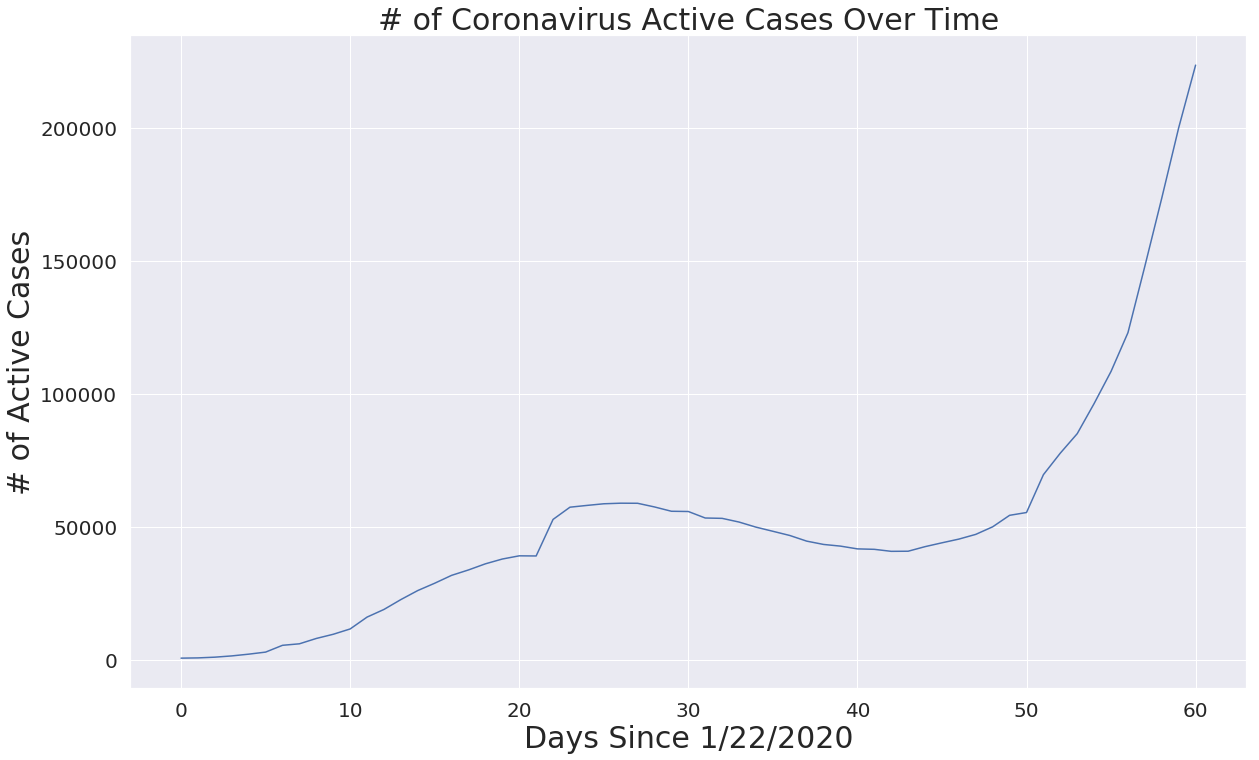

In [33]:
plt.figure(figsize=(20, 12))
sns.lineplot(data=world_full.reset_index()['total_active'])

plt.title('# of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Active Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

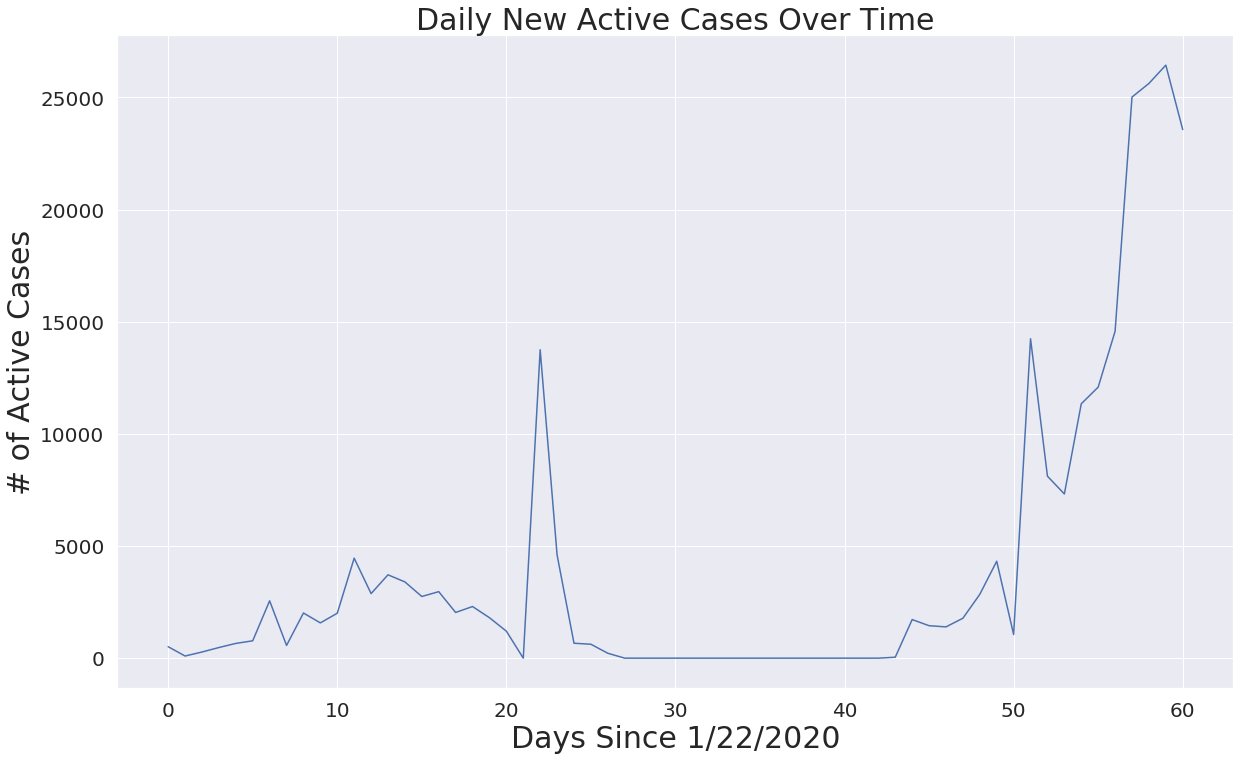

In [34]:
plt.figure(figsize=(20, 12))
sns.lineplot(data=world_full.reset_index()['new_active'])

plt.title('Daily New Active Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Active Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

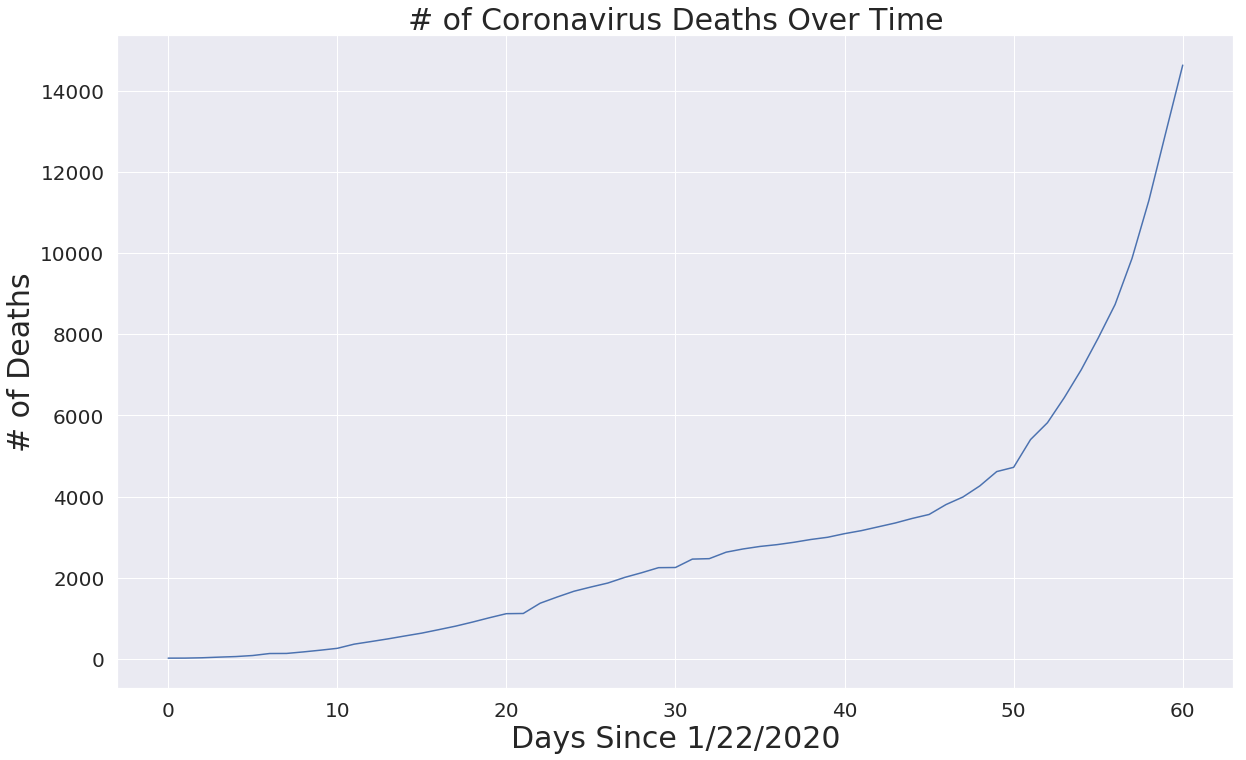

In [35]:
plt.figure(figsize=(20, 12))
sns.lineplot(data=world_full.reset_index()['total_death'])
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

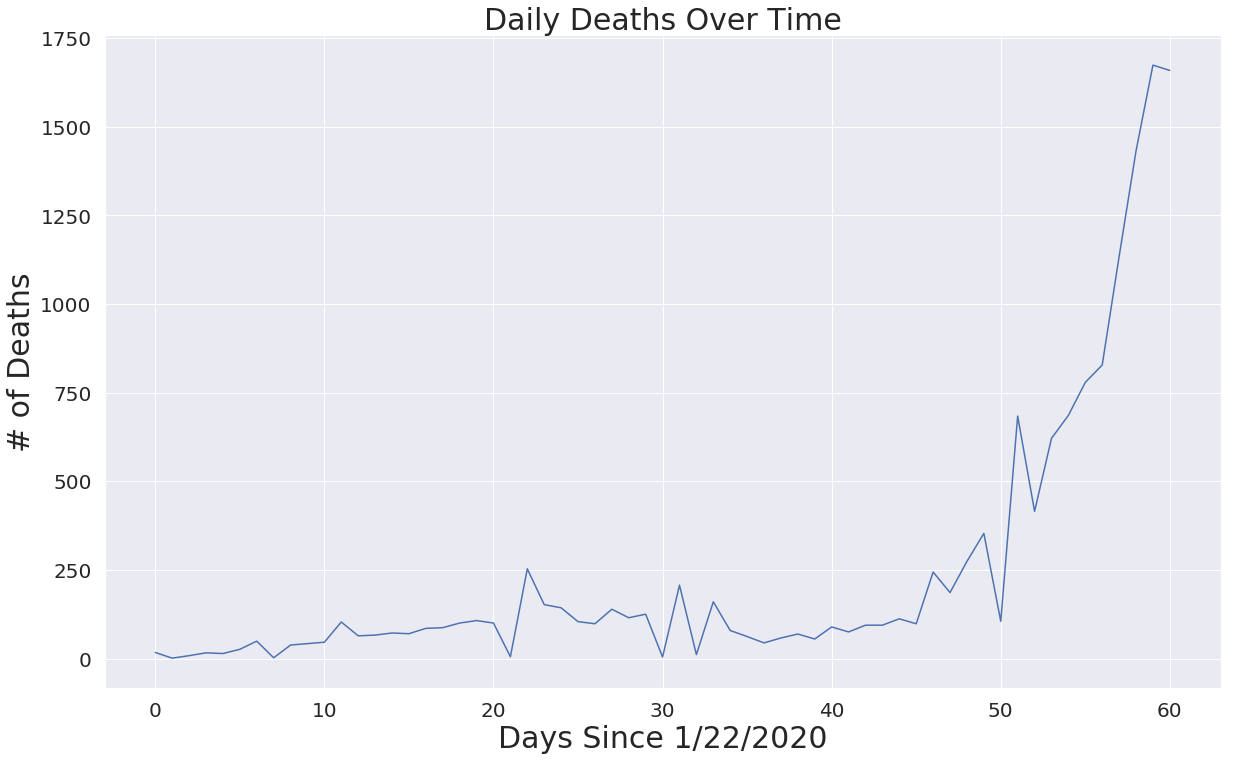

In [36]:
plt.figure(figsize=(20, 12))
sns.lineplot(data=world_full.reset_index()['new_death'])
plt.title('Daily Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

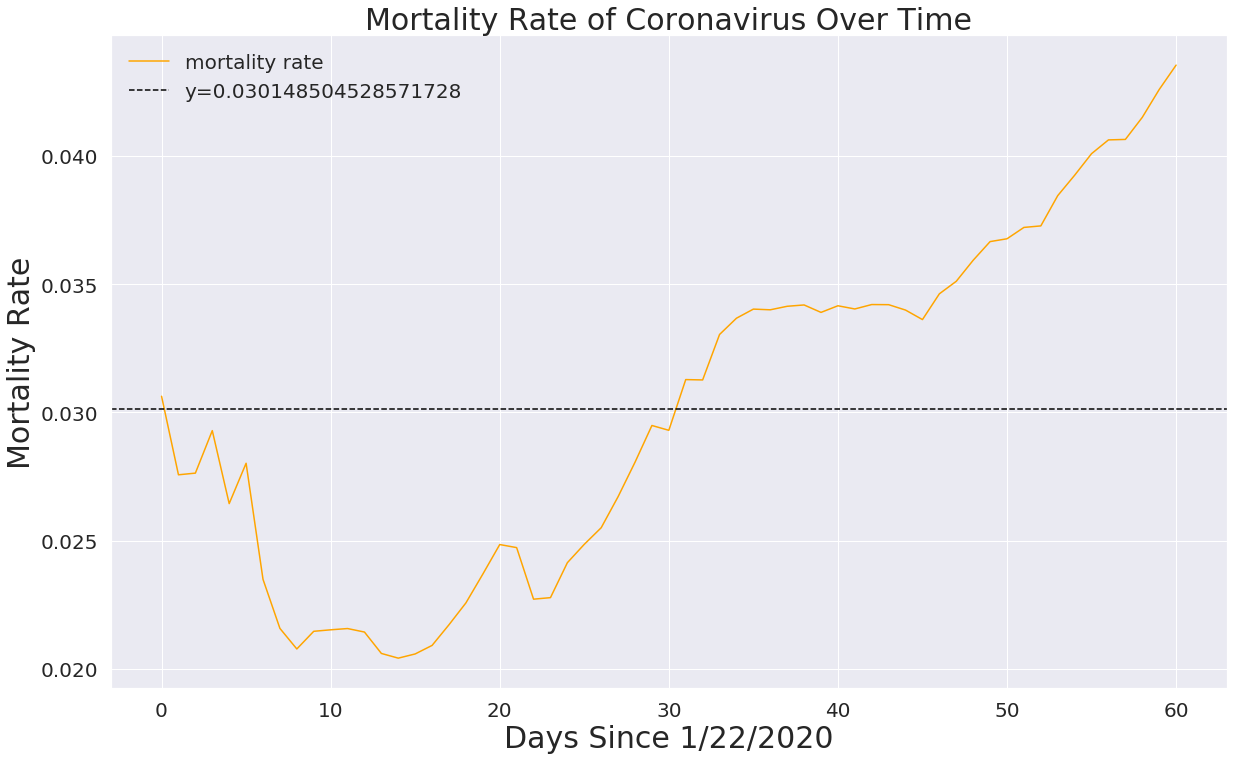

In [37]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

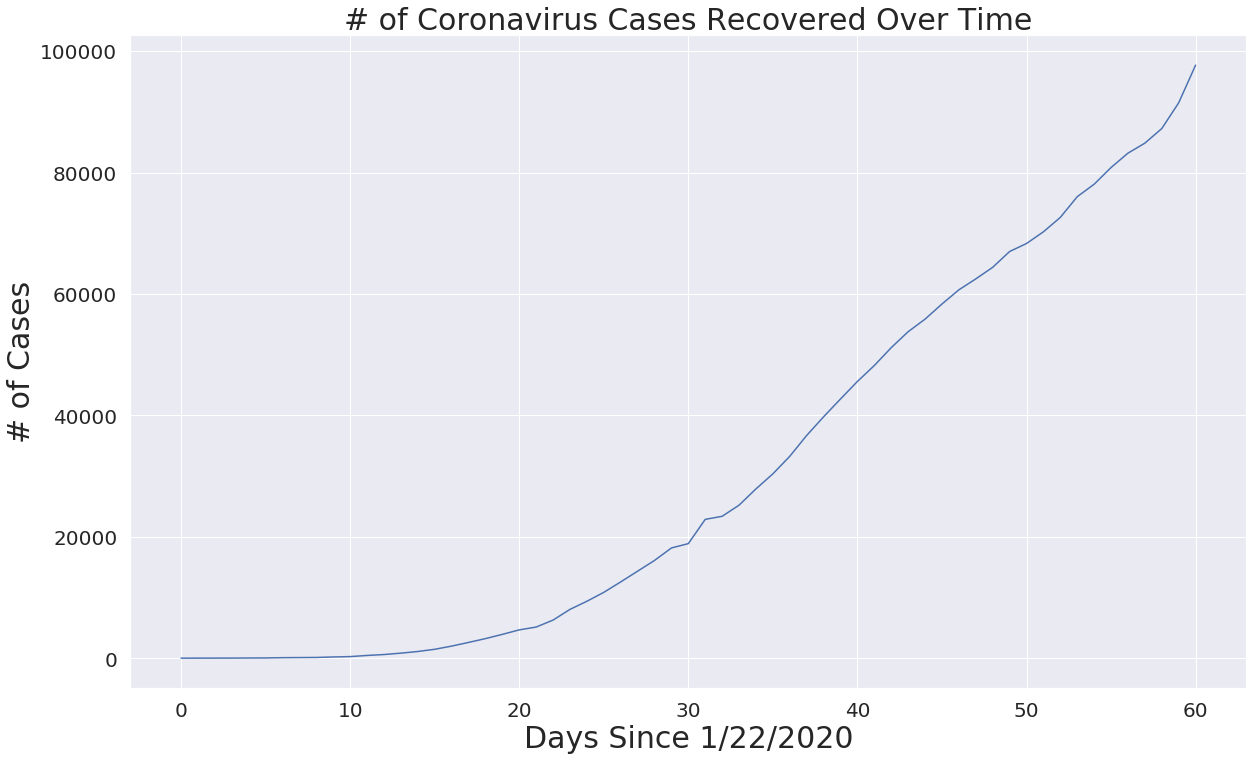

In [38]:
plt.figure(figsize=(20, 12))
sns.lineplot(data=world_full.reset_index()['total_recovered'])


plt.title('# of Coronavirus Cases Recovered Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

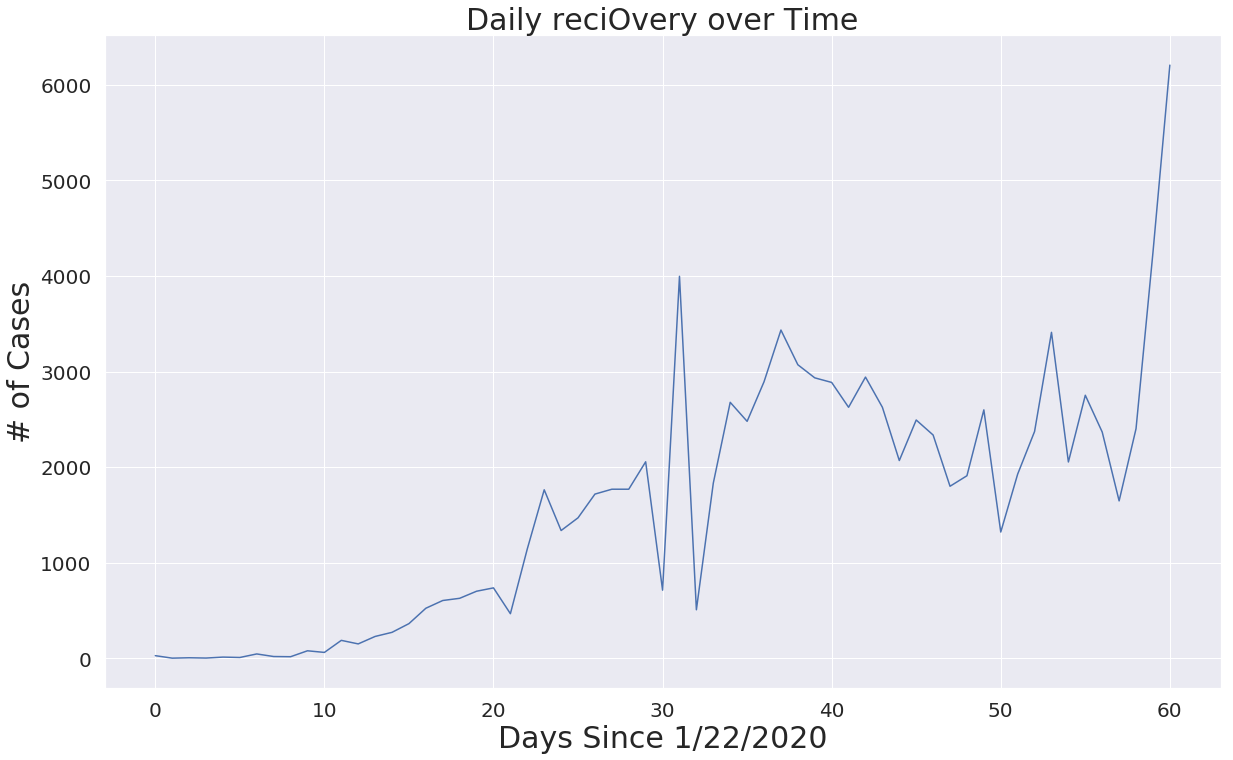

In [39]:
plt.figure(figsize=(20, 12))

sns.lineplot(data=world_full.reset_index()['new_reco'])

plt.title('Daily reciOvery over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

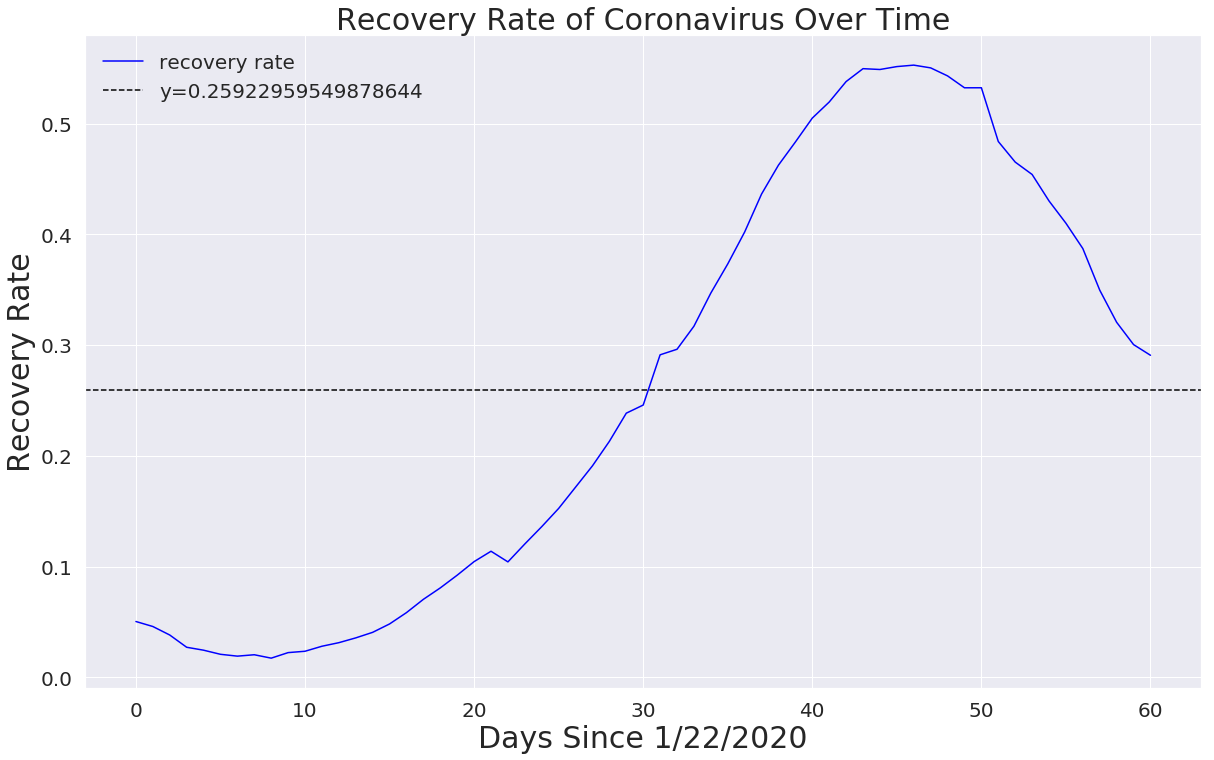

In [40]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, recovery_rate, color='blue')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Recovery Rate of Coronavirus Over Time', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Graphing deaths against recoveries

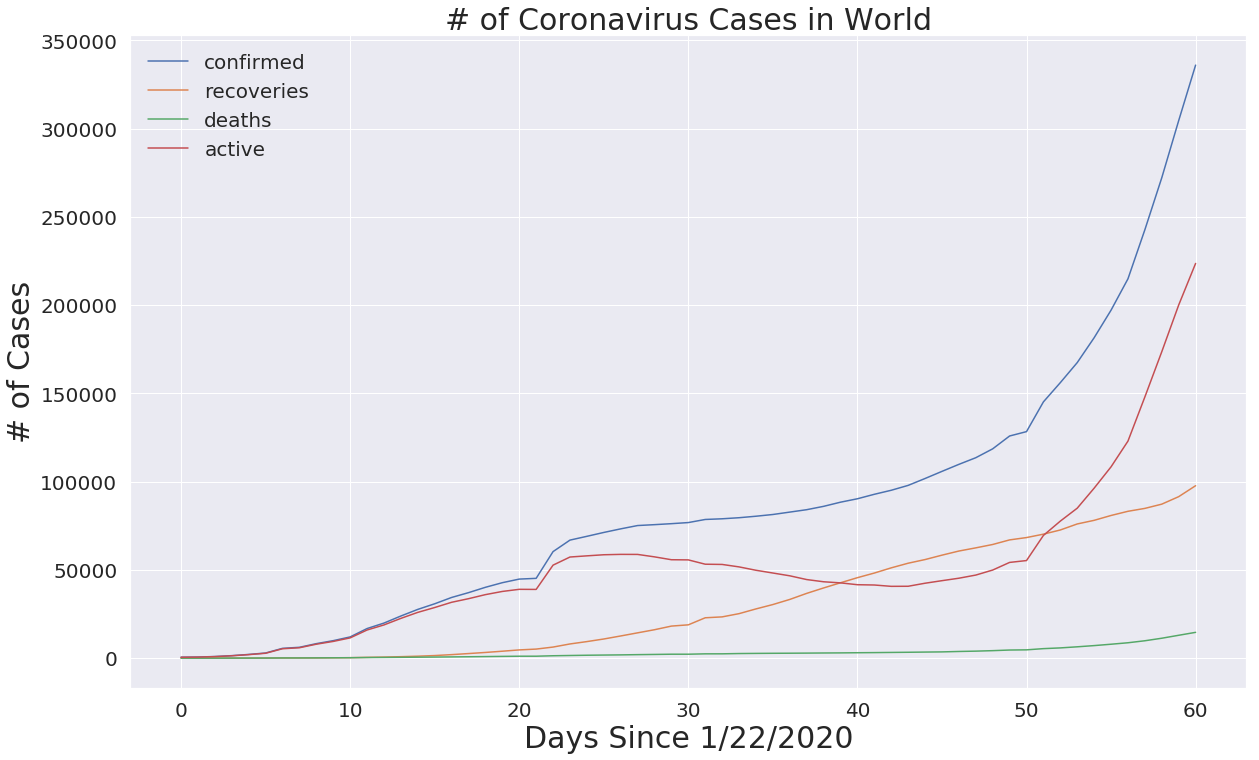

In [41]:
plt.figure(figsize=(20, 12))
sns.lineplot(data=world_full.reset_index()['conf_cases'] );
sns.lineplot(data=world_full.reset_index()['total_recovered'])
sns.lineplot(data=world_full.reset_index()['total_death'])
sns.lineplot(data=world_full.reset_index()['total_active'])


plt.legend(['confirmed', 'recoveries','deaths','active'], loc='best', fontsize=20)
plt.title('# of Coronavirus Cases in World', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [42]:
india_full.head(2)

,conf_cases,reco_cases,death_cases,activ_cases
1/22/20,0,0,0,0
1/23/20,0,0,0,0


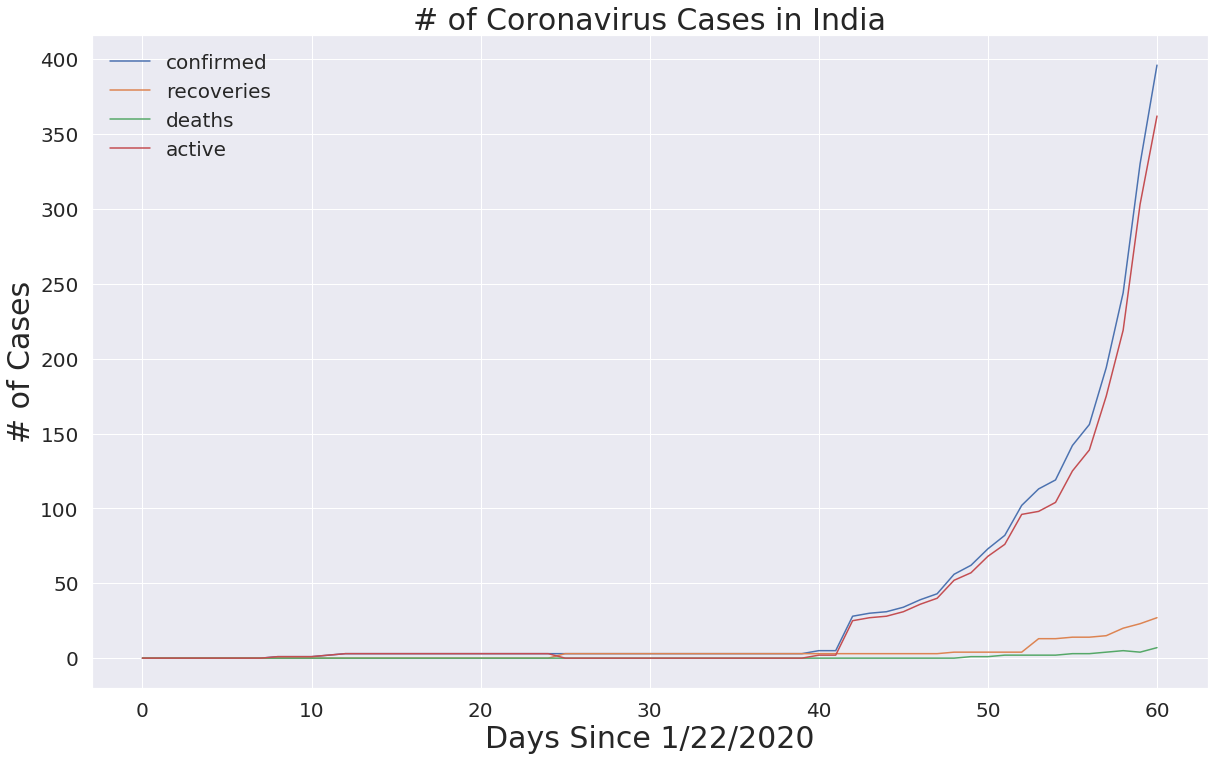

In [43]:
plt.figure(figsize=(20, 12))
sns.lineplot(data=india_full.reset_index()['conf_cases'])
sns.lineplot(data=india_full.reset_index()['reco_cases'])
sns.lineplot(data=india_full.reset_index()['death_cases'])
sns.lineplot(data=india_full.reset_index()['activ_cases'])


plt.legend(['confirmed', 'recoveries','deaths','active'], loc='best', fontsize=20)
plt.title('# of Coronavirus Cases in India', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

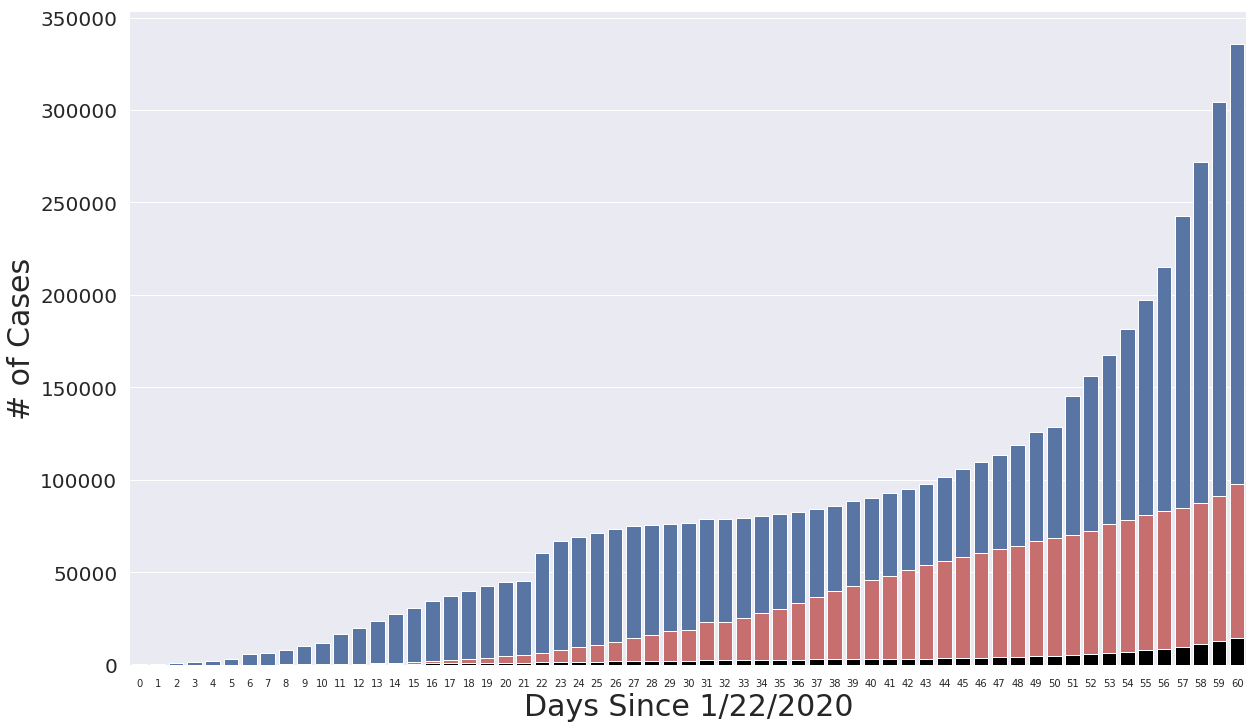

In [44]:
f, ax = plt.subplots(figsize=(20, 12))

# Load the example car crash dataset
sns.set_color_codes("deep")
sns.barplot(x =world_full.reset_index().index,y=world_full.reset_index()['conf_cases'] , label = 'Confirmed',color ='b');

sns.set_color_codes("muted")
sns.barplot(x =world_full.reset_index().index,y=world_full.reset_index()['total_recovered'] , label = 'Recovered',color ='r');


sns.set_color_codes("muted")
sns.barplot(x =world_full.reset_index().index,y=world_full.reset_index()['total_death'] , label = 'Deaths',color ='black');
# Add a legend and informative axis label
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)

#ax.legend(ncol=1, loc="upper right", frameon=True)
#ax.set(xlim=(0, 60) ,ylabel="no of people",
#       xlabel="# of cases ")
sns.despine(left=True, bottom=True)
plt.xticks(size=10)
plt.yticks(size=20)
plt.show()

In [45]:
world_full.reset_index()[['conf_cases','total_death','total_recovered']]
world_full.head(2)

,conf_cases,daily_new_cases,total_recovered,new_reco,total_death,new_death,total_active,new_active
1/22/20,555,555,28,28,17,17,510,510
1/23/20,653,98,30,2,18,1,605,95


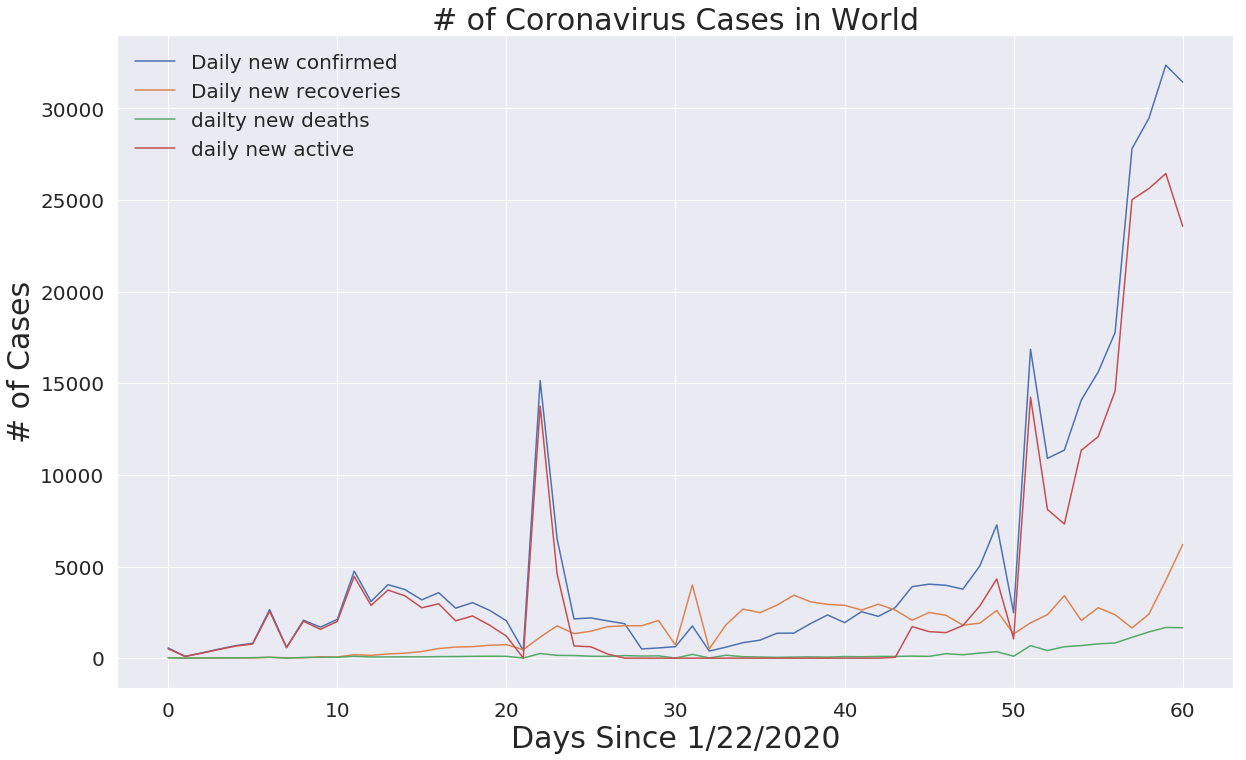

In [46]:
plt.figure(figsize=(20, 12))
sns.lineplot(data=world_full.reset_index()['daily_new_cases'] ,markers=True );
sns.lineplot(data=world_full.reset_index()['new_reco'])
sns.lineplot(data=world_full.reset_index()['new_death'])
sns.lineplot(data=world_full.reset_index()['new_active'])


plt.legend(['Daily new confirmed', 'Daily new recoveries','dailty new deaths','daily new active'], loc='best', fontsize=20)
plt.title('# of Coronavirus Cases in World', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Plotting the number of deaths against the number of recoveries

In [47]:
# plt.figure(figsize=(20, 12))
# plt.plot(total_recovered, total_deaths)
# plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=30)
# plt.xlabel('# of Coronavirus Recoveries', size=30)
# plt.ylabel('# of Coronavirus Deaths', size=30)
# plt.xticks(size=20)
# plt.yticks(size=20)
# plt.show()

In [48]:
latest_confirmed = conf_df[dates[-1]]
latest_deaths = death_df[dates[-1]]
latest_recoveries = reco_df[dates[-1]]

Getting information about countries/regions that have confirmed coronavirus cases

In [52]:
unique_countries =  list(conf_df['Country/Region'].unique())

In [53]:
country_confirmed_cases = []
no_cases = []
for i in unique_countries:
    cases = latest_confirmed[conf_df['Country/Region']==i].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_confirmed[conf_df['Country/Region']==unique_countries[i]].sum()

In [54]:
# number of cases per country/region
print('Confirmed Cases by Countries/Regions:')
for i in range(len(unique_countries)):
    print(f'{unique_countries[i]}: {country_confirmed_cases[i]} cases')

Confirmed Cases by Countries/Regions:
China: 81397 cases
Italy: 59138 cases
US: 33272 cases
Spain: 28768 cases
Germany: 24873 cases
Iran: 21638 cases
France: 16176 cases
Korea, South: 8897 cases
Switzerland: 7245 cases
United Kingdom: 5741 cases
Netherlands: 4216 cases
Belgium: 3401 cases
Austria: 3244 cases
Norway: 2383 cases
Sweden: 1934 cases
Portugal: 1600 cases
Brazil: 1593 cases
Denmark: 1514 cases
Canada: 1465 cases
Australia: 1314 cases
Malaysia: 1306 cases
Turkey: 1236 cases
Czechia: 1120 cases
Japan: 1086 cases
Israel: 1071 cases
Ireland: 906 cases
Luxembourg: 798 cases
Ecuador: 789 cases
Pakistan: 776 cases
Cruise Ship: 712 cases
Poland: 634 cases
Chile: 632 cases
Finland: 626 cases
Greece: 624 cases
Thailand: 599 cases
Iceland: 568 cases
Indonesia: 514 cases
Saudi Arabia: 511 cases
Qatar: 494 cases
Singapore: 455 cases
Romania: 433 cases
Slovenia: 414 cases
India: 396 cases
Philippines: 380 cases
Russia: 367 cases
Peru: 363 cases
Bahrain: 332 cases
Egypt: 327 cases
Estonia:

Getting the latest information about provinces/states that have confirmed coronavirus cases

In [55]:
# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

***Visual Representations*** (bar charts and pie charts)

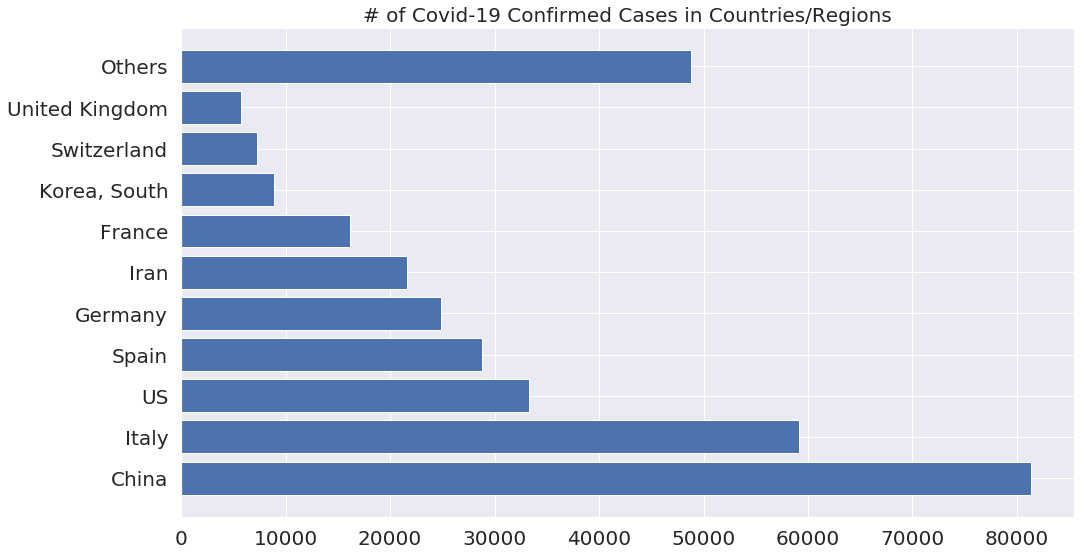

In [56]:
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title('# of Covid-19 Confirmed Cases in Countries/Regions', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

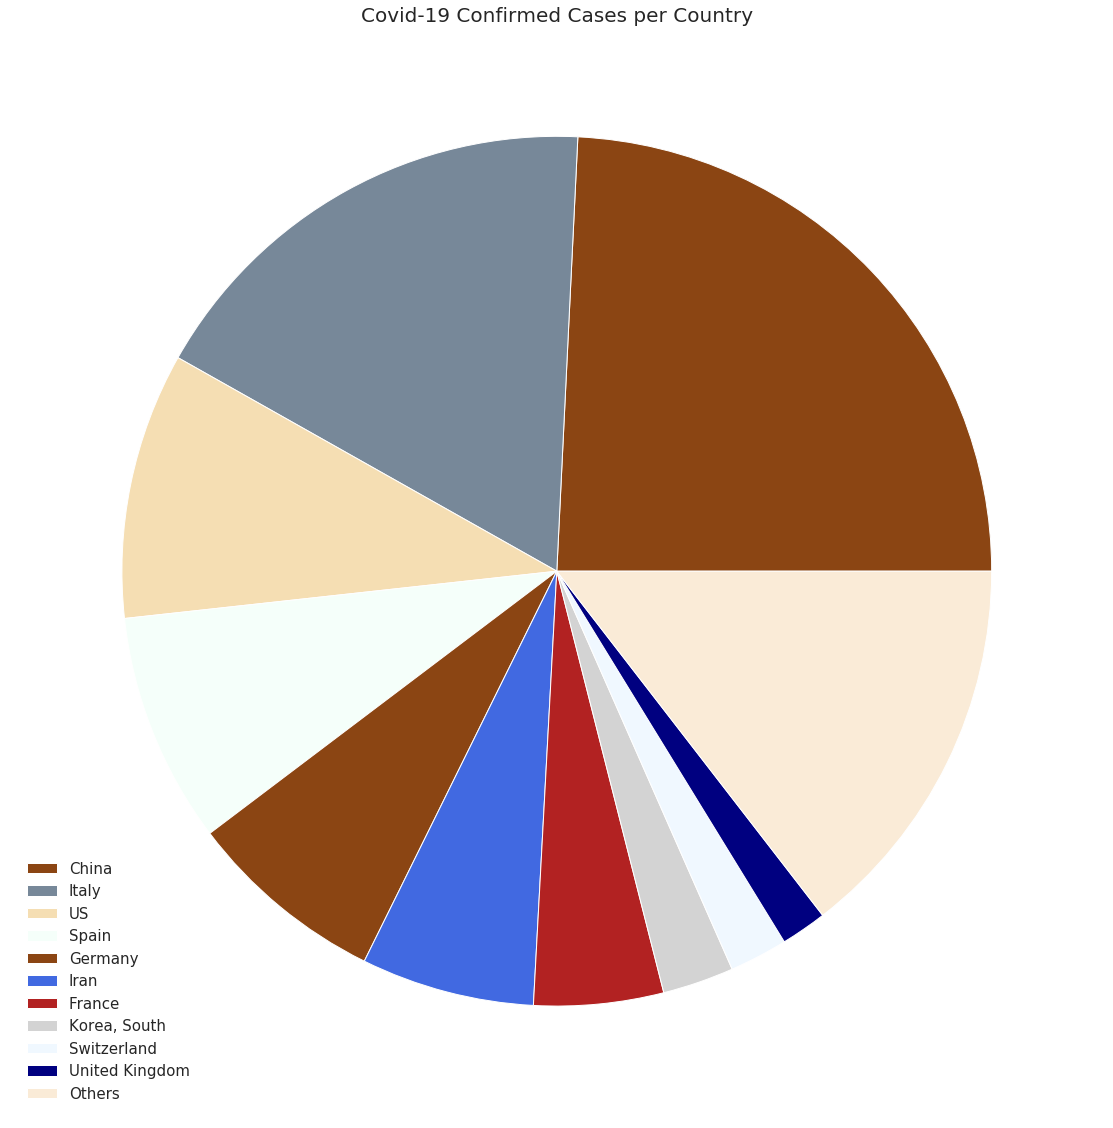

In [57]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases per Country', size=20)
plt.pie(visual_confirmed_cases, colors=c)
plt.legend(visual_unique_countries, loc='best', fontsize=15)
plt.show()

In [63]:
us_regions = list(conf_df[conf_df['Country/Region']=='India']['Province/State'].unique())
us_confirmed_cases = []
no_cases = [] 
for i in us_regions:
    cases = latest_confirmed[conf_df['Province/State']==i].sum()
    if cases > 0:
        us_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    us_regions.remove(i)

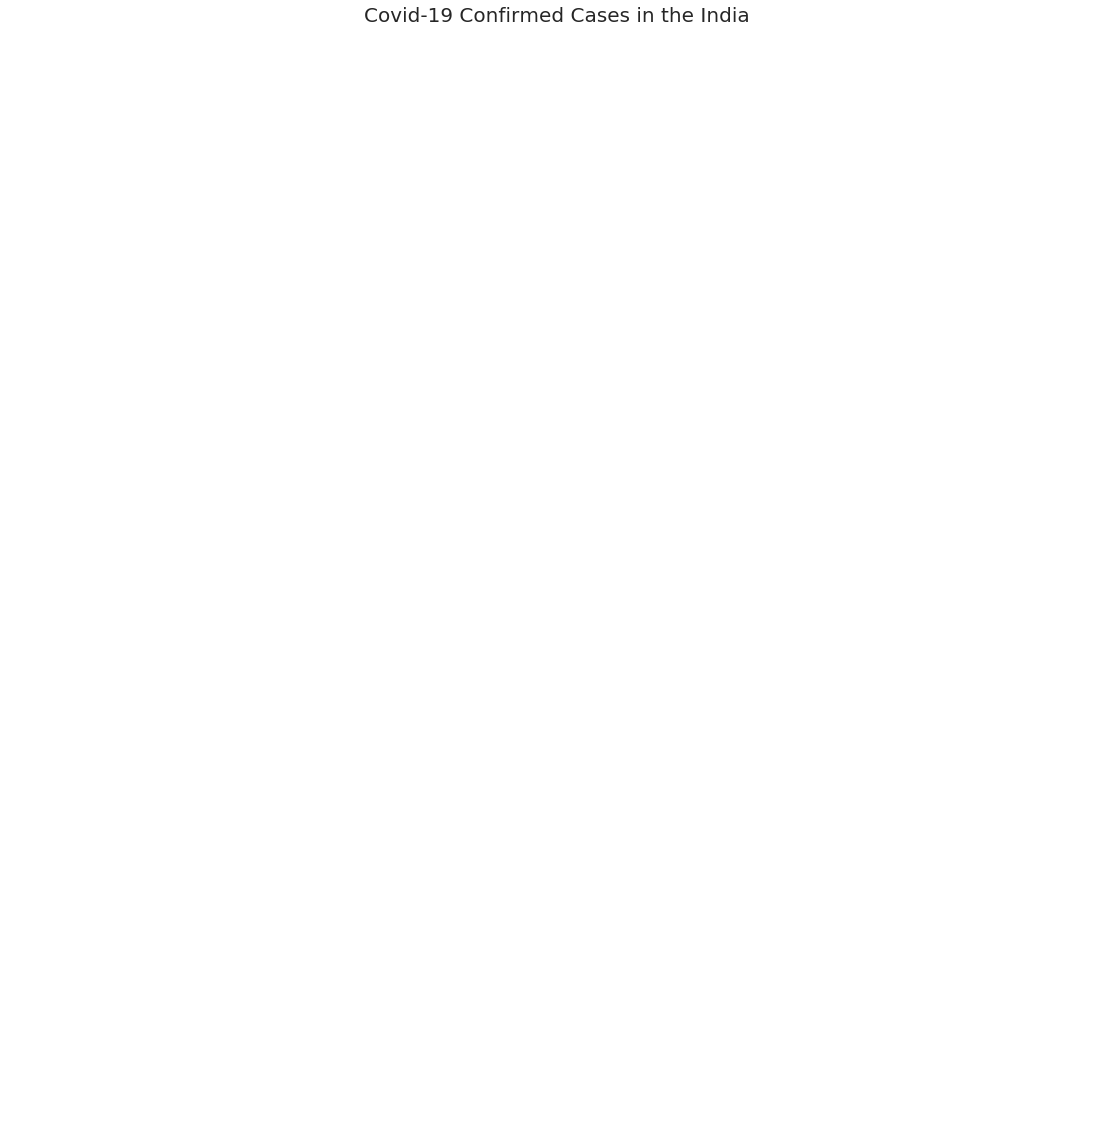

In [65]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases in the India',  size=20)
plt.pie(us_confirmed_cases, colors=c)
plt.legend(us_regions, loc='best', fontsize=15)
plt.show()

In [66]:
china_regions = list(confirmed_df[confirmed_df['Country/Region']=='China']['Province/State'].unique())
china_confirmed_cases = []
no_cases = [] 
for i in china_regions:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        china_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    china_confirmed_cases.remove(i)

NameError: name 'confirmed_df' is not defined

NameError: name 'china_confirmed_cases' is not defined

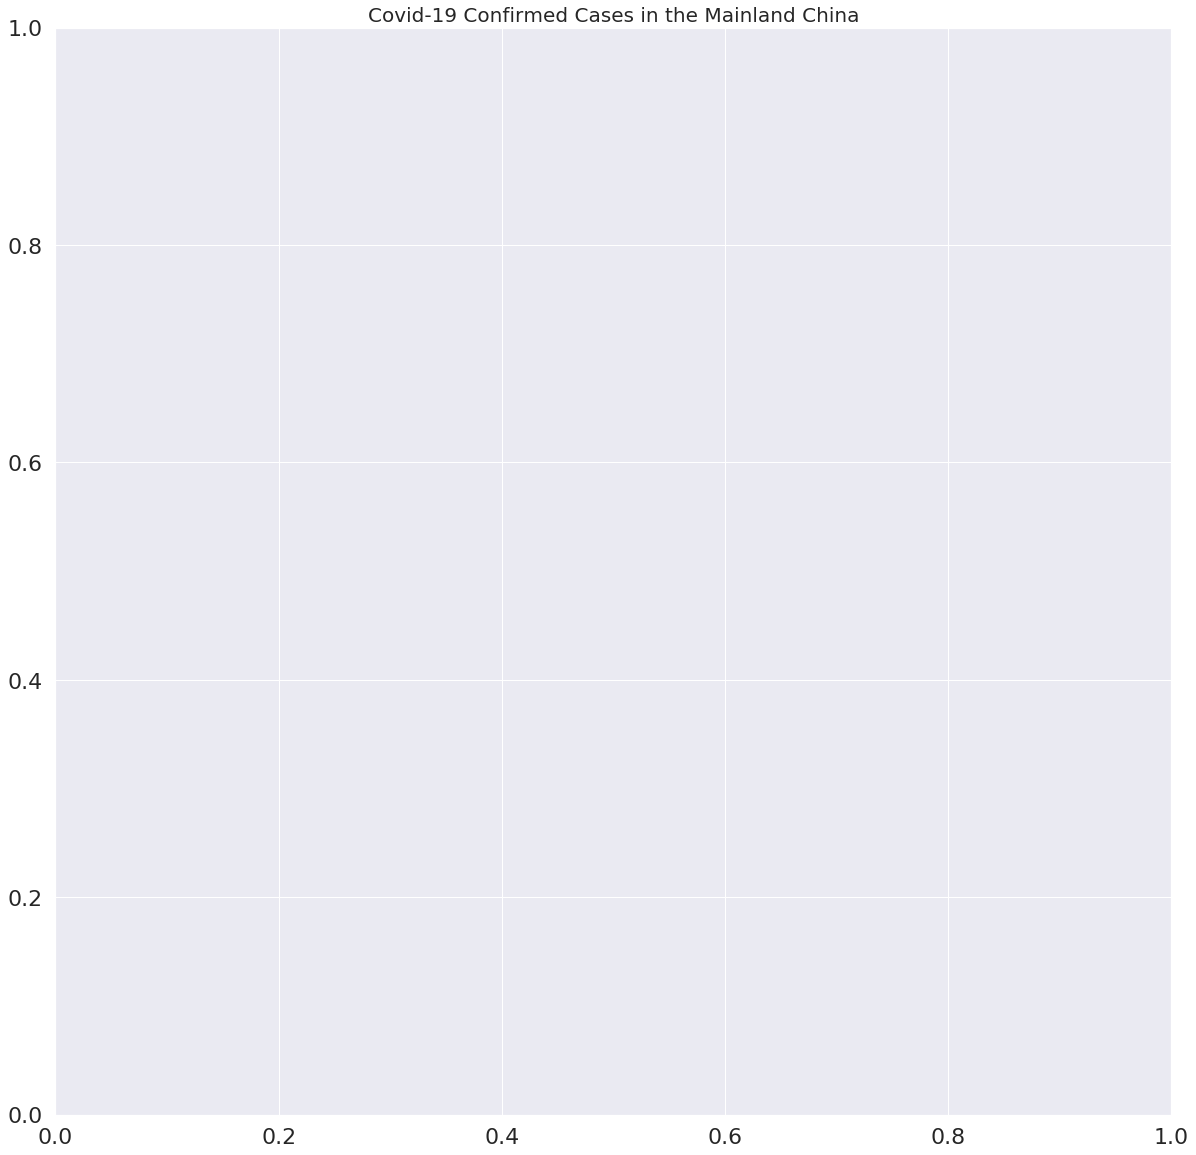

In [67]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases in the Mainland China', size=20)
plt.pie(china_confirmed_cases, colors=c)
plt.legend(china_regions, loc='best', fontsize=15)
plt.show()